# What are the effects of learning rates?
Up till now, the accuracy is not more than 0.8; while other probing works (Hewitt, Pimentel, Viota) all got 90+ acc. Why?  
- Look into the learning rates correlated with accuracy of experiments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict

from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# https://matplotlib.org/examples/color/named_colors.html

from utils import timed_func, combine_df

In [2]:
def find_df_by_lang(lang):
    archive = "../src/archive"
    fnames = [
        #"20200502_sweep"
        "20200516_en_fr_es_maxgradstep_96000"
    ]
    dfs = []
    for fn in fnames:
        df = combine_df(os.path.join(archive, fn))
        dfs.append(df)
    long_df = pd.concat(dfs)
    return long_df[long_df.lang==lang]

df = find_df_by_lang("en")
print(df.shape)
df.head()

(792, 15)


,lm,lang,task,layer,dim,batch_size,init_lr*1e6,weight_decay,lr_anneal,max_grad_step,train_steps,seed,devloss,testloss,acc
0,bertmulti,en,probe,0,10,32,100.0,0.0,0.5,96000,36582,73,1.395917,1.362264,67.754686
1,bertmulti,en,probe,0,10,32,100.0,0.0,0.5,96000,48776,421,1.332736,1.306071,69.947724
2,bertmulti,en,probe,0,10,32,100.0,0.0,0.5,96000,96000,9973,1.475114,1.439865,65.242892
3,bertmulti,en,probe,0,10,32,100.0,0.0,0.5,96000,48776,361091,1.405281,1.369657,66.764418
4,bertmulti,en,ctarget,0,10,32,100.0,0.0,0.5,96000,30485,73,2.833288,2.833213,5.933104


In [3]:
def groupby_return_df(df, group_features, task_features):
    dfs = {}
    for ft in group_features:
        dfs[ft] = []
    for ft in task_features:
        dfs[ft] = []
    df_with_mean = df.groupby(group_features).mean()
    for idx, row in df_with_mean.iterrows():
        for j, ft in enumerate(group_features):
            dfs[ft].append(idx[j])
        for j, ft in enumerate(task_features):
            dfs[ft].append(row[ft])
    return pd.DataFrame(dfs)
    
df_with_mean = groupby_return_df(
    find_df_by_lang("en"),
    ["lang", "task", "layer", "dim", "init_lr*1e6", "max_grad_step"],
    ["devloss", "testloss", "acc"]
)
print(df_with_mean.shape)
df_with_mean[["layer", "dim"]].drop_duplicates()

(198, 9)


,layer,dim
0,0,10
6,1,10
12,1,20
18,1,40
24,1,80
30,1,160
36,2,10
42,2,20
48,2,40
54,2,80


18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6


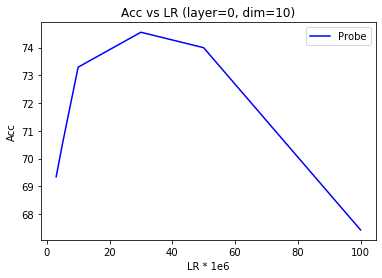

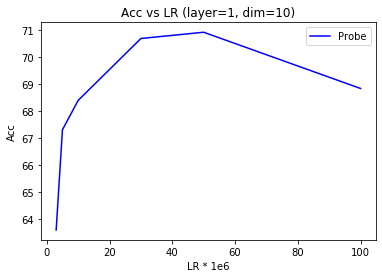

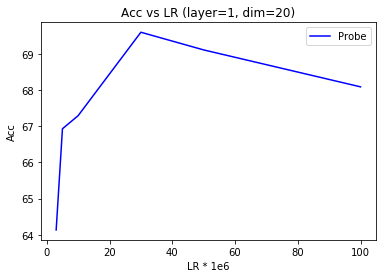

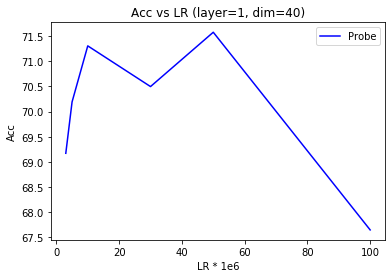

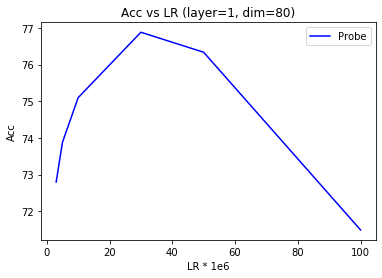

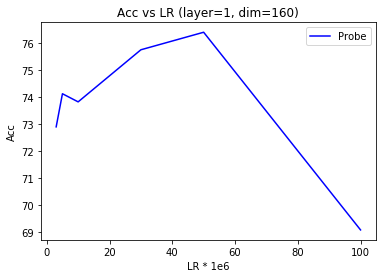

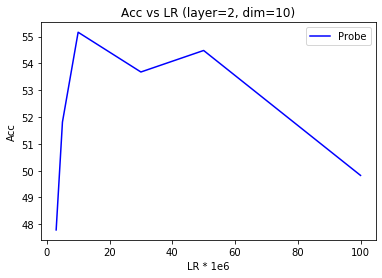

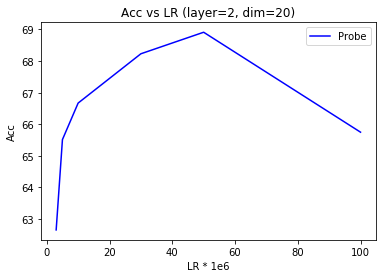

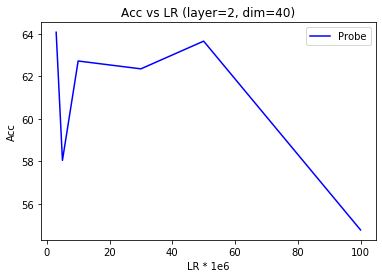

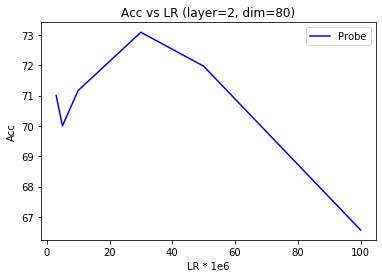

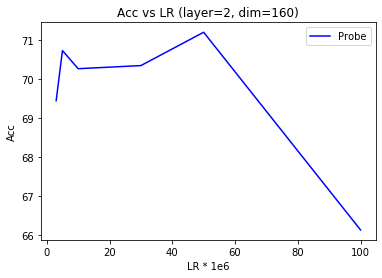

In [51]:
def plot_by_config(df_with_mean, probe_only=False):
    #res_ = {(0, 10): [], (1,10): [], (1,20): [], (1, 40): [], (1, 80): [],
    #      (2, 10): [], (2, 20): [], (2, 40): [], (2, 80): [], (2, 160): []}
    res_ = {(0, 10): [], (1,10): [], (1,20): [], (1, 40): [], (1, 80): [], (1, 160): [],
          (2, 10): [], (2, 20): [], (2, 40): [], (2, 80): [], (2, 160): []}
    
    res = OrderedDict(res_)
    for config in res:
        layer, dim = config
        df_tmp = df_with_mean[(df_with_mean.layer == layer) & (df_with_mean.dim == dim) & \
                              (df_with_mean.max_grad_step == 96000)]
        
        df_probe = df_tmp[df_tmp.task == "probe"]
        df_crep = df_tmp[df_tmp.task == "crep"]
        df_ctarget = df_tmp[df_tmp.task == "ctarget"]
        print (len(df_tmp), len(df_probe), len(df_crep), len(df_ctarget))
        if len(df_tmp) > 0:
            #print(config, len(df_tmp))
            plt.figure()
            plt.plot(df_probe["init_lr*1e6"], df_probe["acc"], label="Probe", c=colors["blue"])
            if not probe_only:
                plt.plot(df_ctarget["init_lr*1e6"], df_ctarget["acc"], label="ctarget", c=colors["green"])
                plt.plot(df_crep["init_lr*1e6"], df_crep["acc"], label="crep", c=colors["lightgreen"])
            plt.ylabel("Acc")
            plt.xlabel("LR * 1e6")
            plt.title("Acc vs LR (layer={}, dim={})".format(layer, dim))
            plt.legend(loc="best")
        
plot_by_config(df_with_mean, probe_only=True)

18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6
18 6 6 6


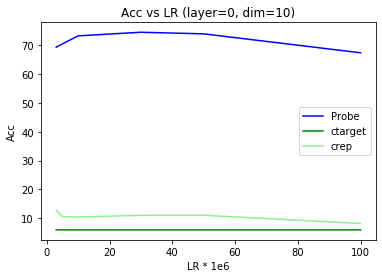

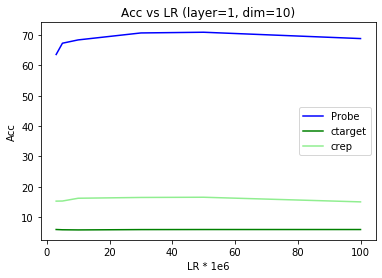

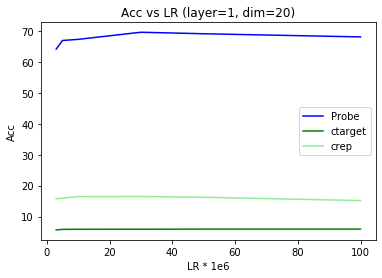

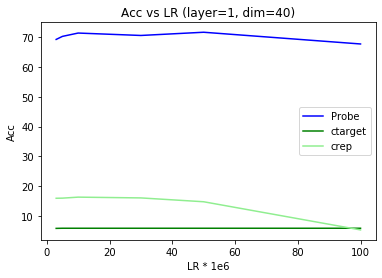

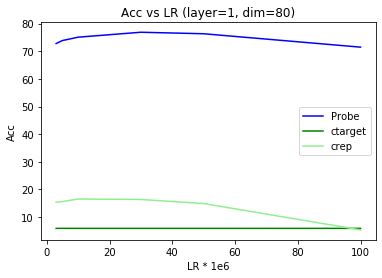

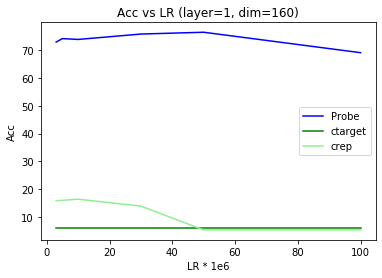

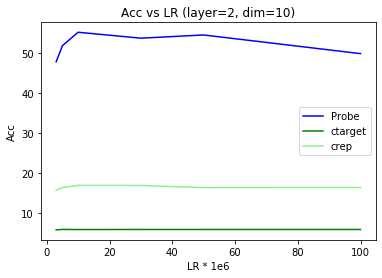

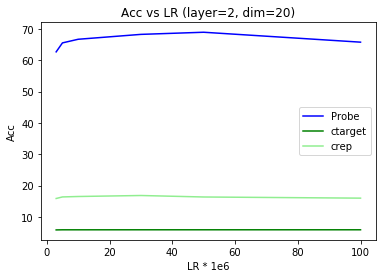

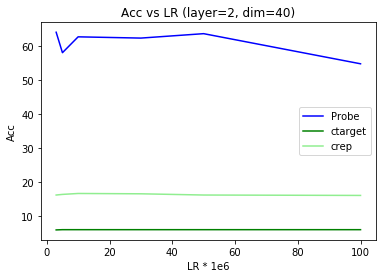

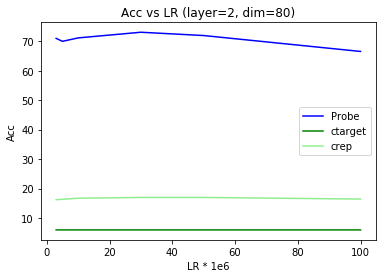

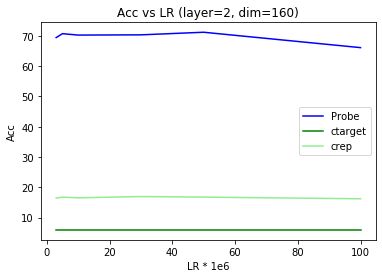

In [52]:
plot_by_config(df_with_mean, probe_only=False)

In [29]:
def plot_by_config_one_fig(df_with_mean, category="acc", lang="en"):
    res_ = {(0, 10): [], (1,10): [], (1,20): [], (1, 40): [], (1, 80): [], (1, 160): [],
          (2, 10): [], (2, 20): [], (2, 40): [], (2, 80): [], (2, 160): []}
    res = OrderedDict(res_)
    plt.figure(figsize=(8,10))
    for config in res:
        layer, dim = config
        df_tmp = df_with_mean[(df_with_mean.layer == layer) & (df_with_mean.dim == dim) & \
                              (df_with_mean.max_grad_step == 96000)]
        df_probe = df_tmp[df_tmp.task == "probe"].sort_values(["init_lr*1e6"])
        df_crep = df_tmp[df_tmp.task == "crep"].sort_values(["init_lr*1e6"])
        df_ctarget = df_tmp[df_tmp.task == "ctarget"].sort_values(["init_lr*1e6"])
        
        x = df_probe["init_lr*1e6"] / (10**6)
        if category == "acc":
            y = df_probe["acc"]
            ylabel = "Accuracy"
        elif category == "loss":
            y = df_probe["testloss"]
            ylabel = "Loss"
        elif category == "hewitt":
            y = df_probe["acc"].values - df_ctarget["acc"].values
            ylabel = "Diff accuracy"
        elif category == "pimentel":
            y = -df_probe["testloss"].values + df_crep["testloss"].values
            ylabel = "Diff loss"
        else:
            raise ValueError
        title = f"{ylabel} vs initial learning rate ({lang})"
            
        if len(df_tmp) > 0:
            if layer == 0:
                c_ = {10: colors["cyan"]}
            elif layer == 1:
                c_ = {10: colors["darkgreen"], 20: colors["green"], 40: colors["seagreen"], 80: colors["limegreen"], 160: colors["yellowgreen"]}
            else:
                c_ = {10: colors["magenta"], 20: colors["violet"], 40: colors["deeppink"], 80: colors["hotpink"], 160: colors["pink"]}
            plt.plot(x, y, label="layer{} dim{}".format(layer, dim), c=c_[dim], linestyle="dashdot")
    plt.ylabel(ylabel)
    plt.xlabel("init_lr")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    
    plt.savefig("0519/{}_learning_rate_{}.png".format(category, lang), dpi=300)

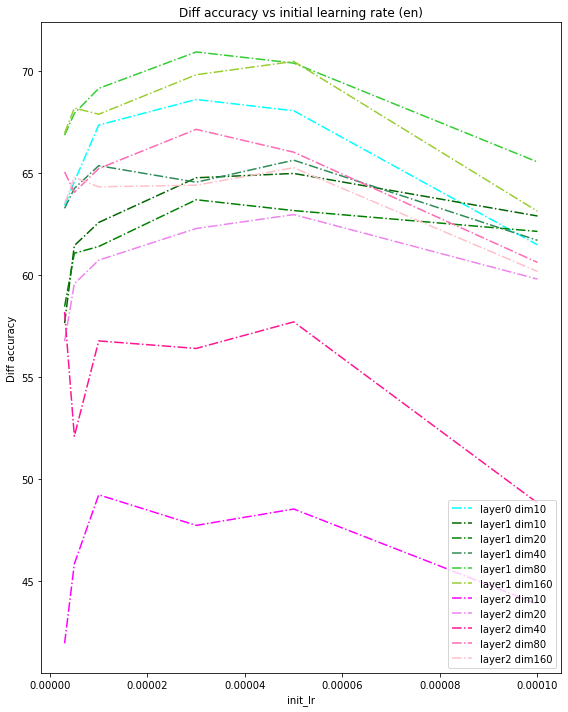

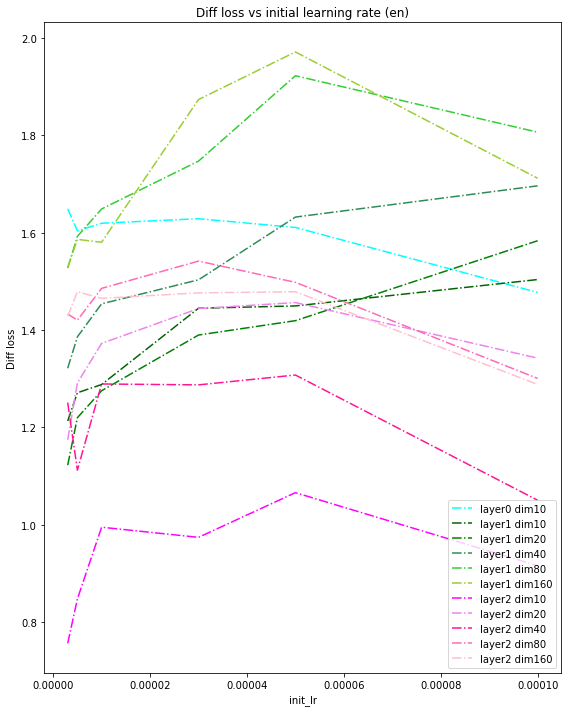

In [30]:
plot_by_config_one_fig(df_with_mean, "hewitt", "en")
plot_by_config_one_fig(df_with_mean, "pimentel", "en")

(198, 9)


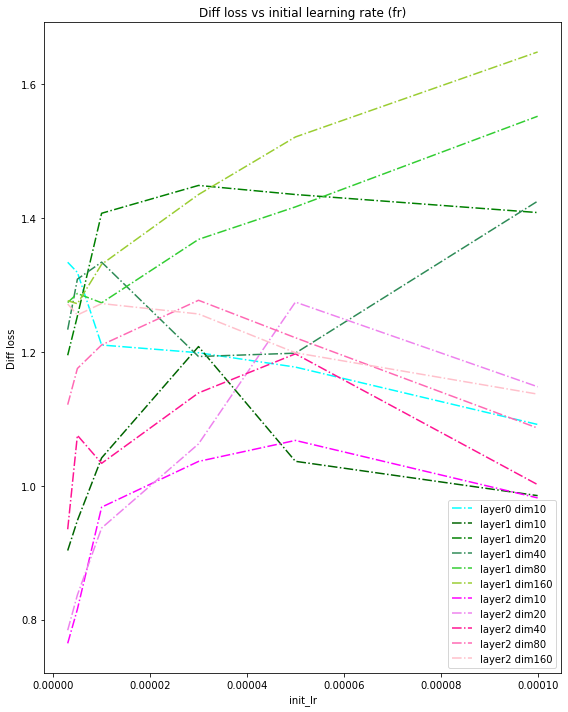

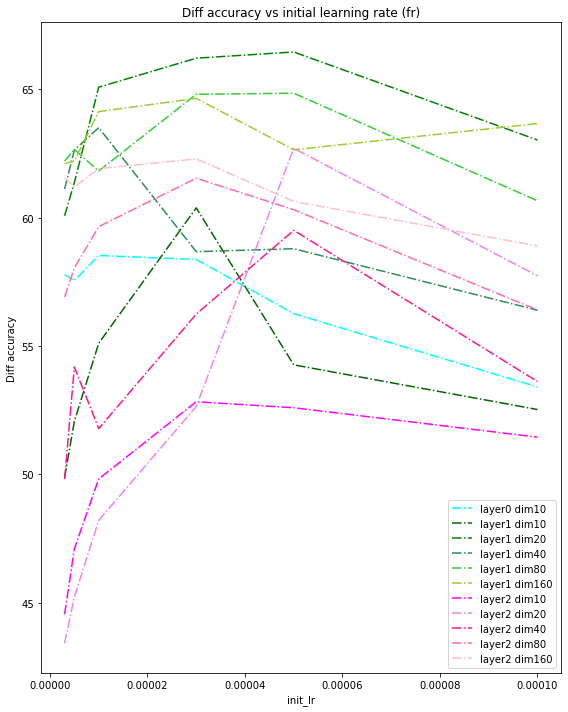

In [73]:
df_with_mean = groupby_return_df(
    find_df_by_lang("fr"),
    ["lang", "task", "layer", "dim", "init_lr*1e6", "max_grad_step"],
    ["devloss", "testloss", "acc"]
)
print(df_with_mean.shape)
df_with_mean[["layer", "dim"]].drop_duplicates()
plot_by_config_one_fig(df_with_mean, "pimentel", "fr")
plot_by_config_one_fig(df_with_mean, "hewitt", "fr")

(198, 9)


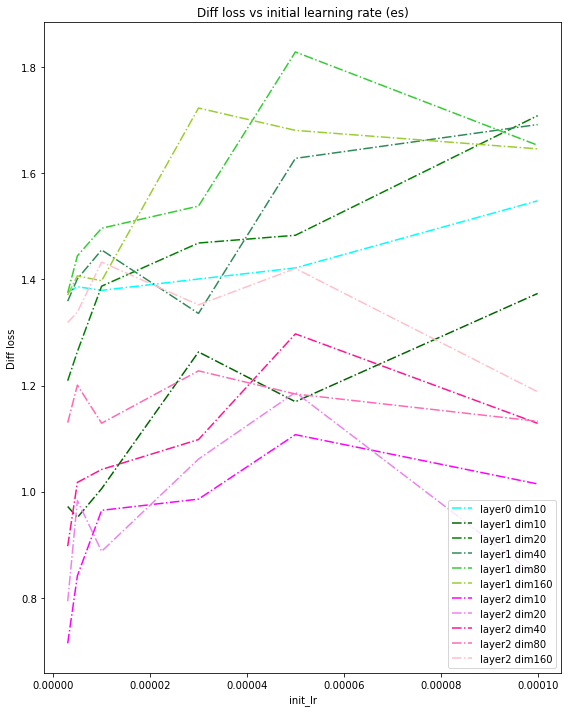

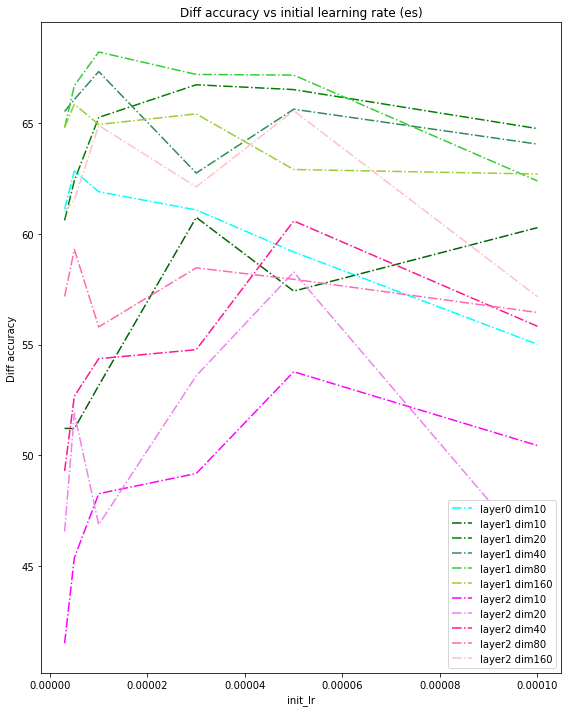

In [74]:
df_with_mean = groupby_return_df(
    find_df_by_lang("es"),
    ["lang", "task", "layer", "dim", "init_lr*1e6", "max_grad_step"],
    ["devloss", "testloss", "acc"]
)
print(df_with_mean.shape)
df_with_mean[["layer", "dim"]].drop_duplicates()
plot_by_config_one_fig(df_with_mean, "pimentel", "es")
plot_by_config_one_fig(df_with_mean, "hewitt", "es")